# Performance analysis
In this notebook we analyzes the performance of the graph network in clustering and classifying the jets

In [32]:
import numpy as np
import torch
import networkx as nx
import matplotlib.pyplot as plt
import os
os.environ['DGLBACKEND'] = 'pytorch'
import dgl

from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from dgl.nn import NNConv, EdgeConv
from dgl.nn.pytorch import Sequential as dglSequential
from dgl.dataloading import GraphDataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm

from tsne_torch import TorchTSNE as TSNE
from kmeans_pytorch import kmeans, kmeans_predict
from sklearn.cluster import KMeans, DBSCAN
from scipy.optimize import linear_sum_assignment
import autoencoders

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


# Graphics parameters

In [2]:
FONTNAME = 'serif'
FONTSIZE = 20

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = FONTNAME

## Define dataset and load model

In [3]:
class GraphDataset(Dataset):
    def __init__(self, data_path, n_files=None, lbl_to_load=None, transform=None):

        self.fnames    = [fname for fname in os.listdir(data_path) if fname.endswith('.dgl')]
        self.data_path = data_path

        if n_files:
            self.fnames = self.fnames[n_files]

        self.transform = transform     
        self.lbl_2_load = lbl_to_load

        self.load_graphs()


    def load_graphs(self):
        self.graphs = []

        for fname in tqdm(self.fnames, 'Reading files'):
            graphs, _ = dgl.load_graphs(os.path.join(self.data_path, fname))
            if self.lbl_2_load:
                self.graphs.extend([graph for graph in graphs if graph.ndata['labels'][0].nonzero().squeeze() in self.lbl_2_load])
            else:
                self.graphs.extend(graphs)


    def __len__(self):

        return len(self.graphs)
    

    def __getitem__(self, idx):

        x = self.graphs[idx]
        
        if self.transform:
            x = self.transform(x)
        
        return x

In [254]:
latent_dim = 6
model_name = f"_6ep32batch{latent_dim}ld_024_E3D1"

### Load encoder directly

In [255]:
encoder = torch.load('models/encoder' + model_name + '.pkl')
encoder.to(device)

Encoder3(
  (conv): Sequential(
    (0): NNConv_handy(
      (mlp): Sequential(
        (0): Sequential(
          (0): Linear(in_features=3, out_features=32, bias=True)
          (1): Dropout(p=0.2, inplace=False)
          (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): ReLU()
        )
        (1): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
          (1): Dropout(p=0.2, inplace=False)
          (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): ReLU()
        )
        (2): Sequential(
          (0): Linear(in_features=64, out_features=128, bias=True)
          (1): Dropout(p=0.2, inplace=False)
          (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): ReLU()
        )
        (3): Linear(in_features=128, out_features=448, bias=True)
        (4): Sigmoid()
      )
      (nnconv): NNConv(
        (

## Read test set

In [8]:
nfiles = slice(11, 12)
lbl_2_load = [0, 1, 2, 3, 4]
test_dataset = GraphDataset('../data/graphdataset/', nfiles)

Reading files:   0%|          | 0/1 [00:00<?, ?it/s]

In [256]:
test_dataloader = GraphDataLoader(test_dataset, shuffle=True, batch_size=8)

## Make predictions

In [257]:
latent_part = []
labels_part = []
for batch in tqdm(test_dataloader):
    encoder.eval()
    labels_part.append(batch.ndata['labels'])
    batch = batch.to(device)
    with torch.no_grad():
        latent_jet = encoder(batch).cpu().detach()
        latent_part.append(latent_jet)
        del latent_jet


latent_part = torch.cat(latent_part)
labels_part = torch.cat(labels_part)

  0%|          | 0/2500 [00:00<?, ?it/s]

## Finally plots!

In [258]:
labels_str = ['Gluon', 'Quark', 'W', 'Z', 'Top', 'Undefined']

  0%|          | 0/21 [00:00<?, ?it/s]

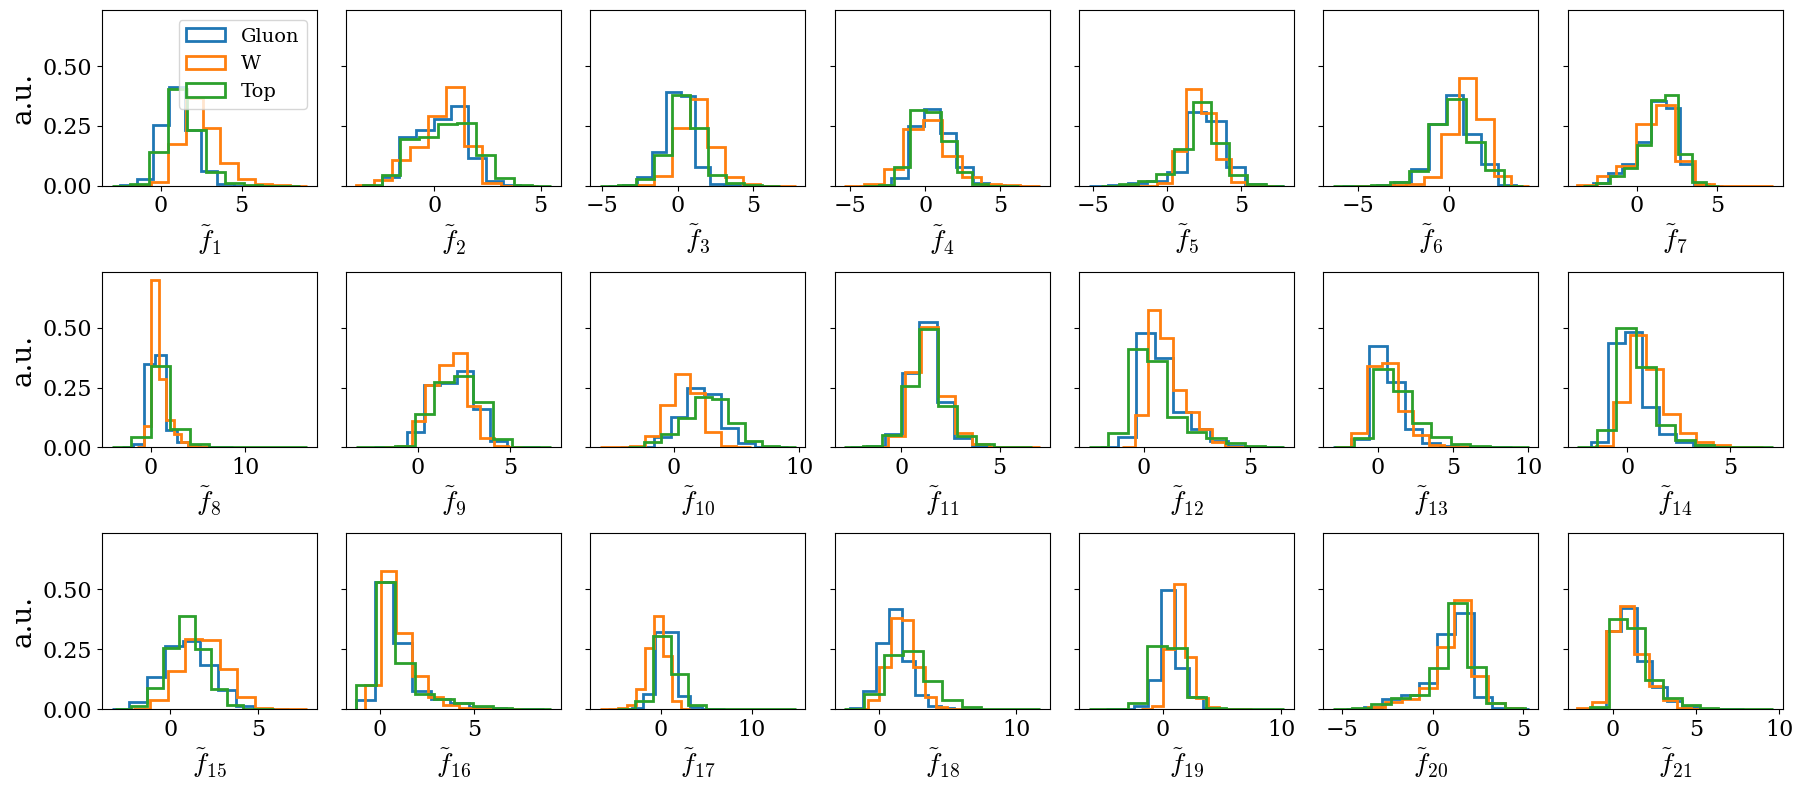

In [259]:

fig, ax = plt.subplots(2, 3, figsize=(15,10), tight_layout=True, sharey=True)

plot_lbl = [0, 2, 4]
def plot_feat_hists(latent_part, labels_part, plot_lbl, latent_dim, ax):
    cols = ax.shape[1]
    ax = ax.flatten()
    for i in tqdm(range(latent_dim)):
        for j in plot_lbl:
            ax[i].hist(latent_part[labels_part[:,j]==1, i], label=labels_str[j], histtype='step', lw=2, density=True)
        ax[i].set_xlabel(r'$\tilde{f}_{' + f'{i+1}' + r'}$', fontsize=FONTSIZE)
        ax[i].tick_params(axis='both', which='major', labelsize=FONTSIZE-4)
        if(i % cols == 0):
            ax[i].set_ylabel('a.u.', fontsize=FONTSIZE)

    ax[0].legend(prop={'size': FONTSIZE-6})

    return ax

ax = plot_feat_hists(latent_part, labels_part, plot_lbl, latent_dim, ax)
#fig.suptitle('Latent space features distributions', fontsize=FONTSIZE+2, fontname=FONTNAME)
plt.show()

In [260]:
fig.savefig('plots/featdist'+model_name+'.pdf')

Final train loss: 0.7732069035371144 val loss: 1.0058532074546562


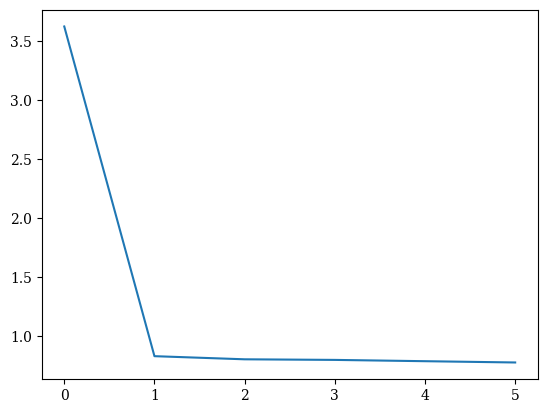

In [261]:
trainloss = np.load('models/trainloss_history'+ model_name +'.npy')
valloss = np.load('models/valloss_history'+ model_name +'.npy')
print('Final train loss:', trainloss[-1], 'val loss:', valloss[-1])
plt.plot(np.arange(len(trainloss)), trainloss)
plt.show()

## Aggregate part into jets

In [262]:
test_dataloader = GraphDataLoader(test_dataset, shuffle=True, batch_size=1)

In [263]:

aggr_func=lambda x, dim : torch.max(x, dim=dim)[0]

latent_jets = []
labels_jets = []
for batch in tqdm(test_dataloader):
    encoder.eval()
    labels_jets.append(batch.ndata['labels'][0])
    batch = batch.to(device)
    with torch.no_grad():
        latent_jet = encoder(batch).detach().cpu()
        latent_jets.append(aggr_func(latent_jet, dim = 0))


latent_jets = torch.stack(latent_jets)
labels_jets = torch.stack(labels_jets)

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

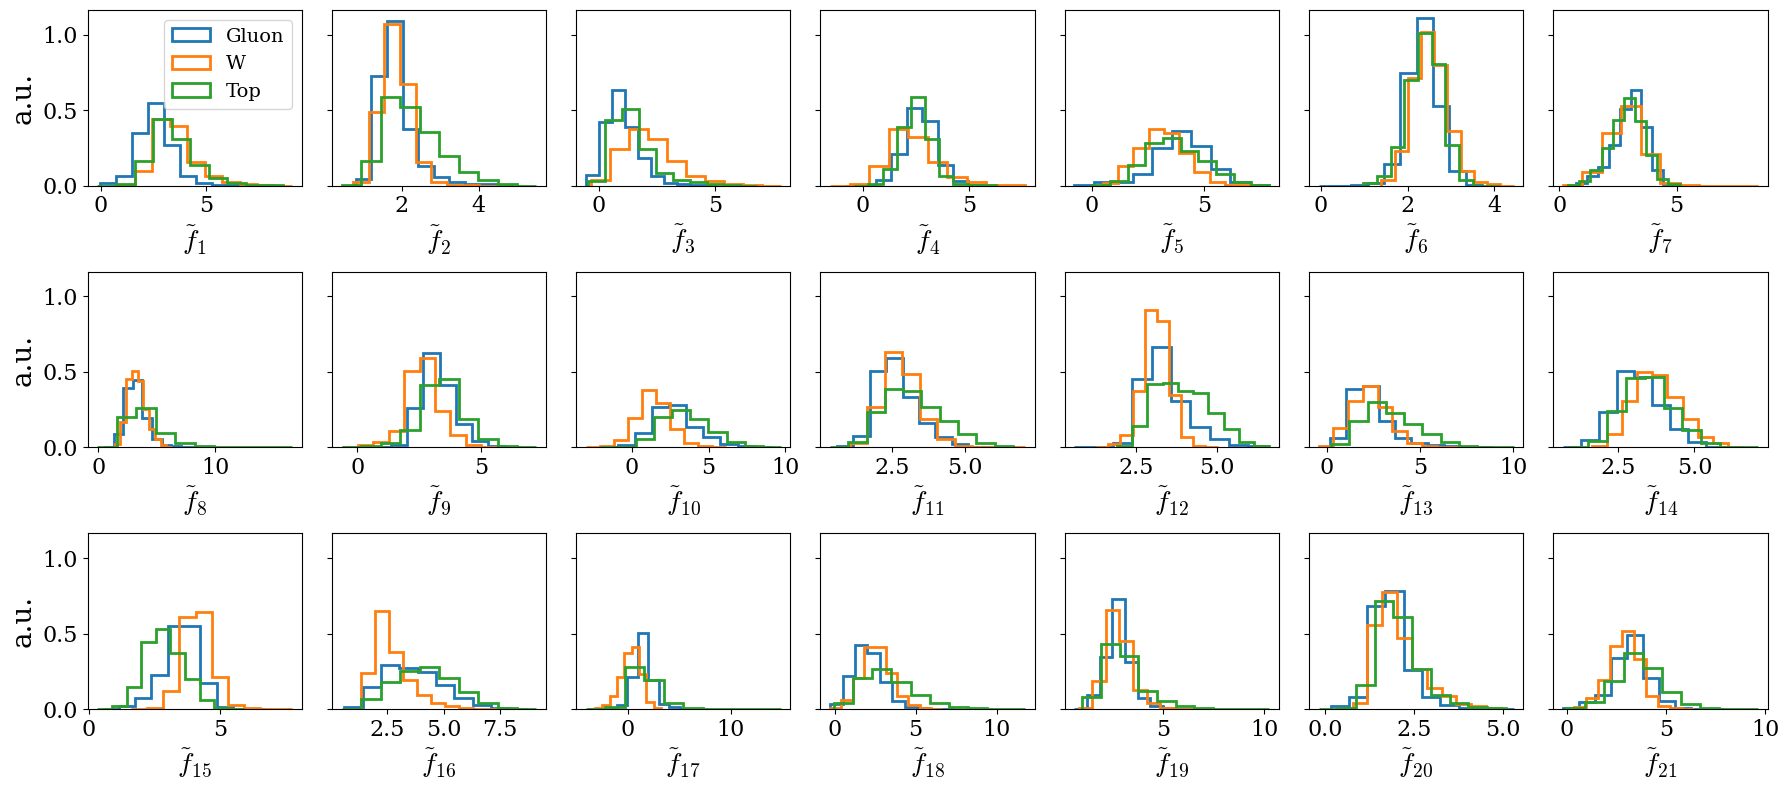

In [264]:
fig_jets, ax = plt.subplots(2, 3, figsize=(15,10), tight_layout=True, sharey=True)
plot_lbl = [0, 2, 4]
ax = plot_feat_hists(latent_jets, labels_jets, plot_lbl, latent_dim, ax)

plt.show()

In [265]:
fig_jets.savefig('plots/featdist_jet'+model_name+'.pdf')

## TSNE

In [143]:
def tsne(latent_jets, labels, target_lbl, ndata=1000, perplexity=20, n_components=2):
    mask = sum([labels.nonzero().squeeze()[:,1] == val for val in target_lbl]).bool()
    X = latent_jets[mask][:ndata]
    lbl = labels[mask][:ndata].nonzero().squeeze()[:,1]
    X_emb = TSNE(n_components=n_components, perplexity=perplexity, n_iter=2000, verbose=True).fit_transform(X)

    return X_emb, lbl

In [144]:
def plot_filtered(X_emb, lbl_emb, plot_lbl, fig, id=111):

    labels_str = ['Gluon', 'Quark', 'W', 'Z', 'Top', 'Undefined']
    n = X_emb.shape[1]
    if n == 2:
        ax = fig.add_subplot(id)

        for j in plot_lbl:
            X_plt = X_emb[lbl_emb==j]
            ax.scatter(X_plt[:,0], X_plt[:,1], label=labels_str[j], s = 24, zorder=5-j)
        
    elif n == 3:
        ax = fig.add_subplot(id, projection='3d')

        for j in plot_lbl:
            X_plt = X_emb[lbl_emb==j]
            ax.scatter(X_plt[:,0], X_plt[:,1], X_plt[:,2], label=labels_str[j], s = 8)

    else:
        print('mannaggia')
        return None
    
    return ax

### 2D

In [279]:
X_emb, lbls = tsne(latent_jets, labels_jets, [0, 2, 4], 2000, perplexity=18)
print(X_emb.shape, lbls.shape)

using cuda
initializing...
skipping PCA because initial_dims is larger than input dimensionality
computing p-values...


  0%|          | 0/2000 [00:00<?, ?it/s]

fitting...


  0%|          | 0/2000 [00:00<?, ?it/s]

(2000, 2) torch.Size([2000])


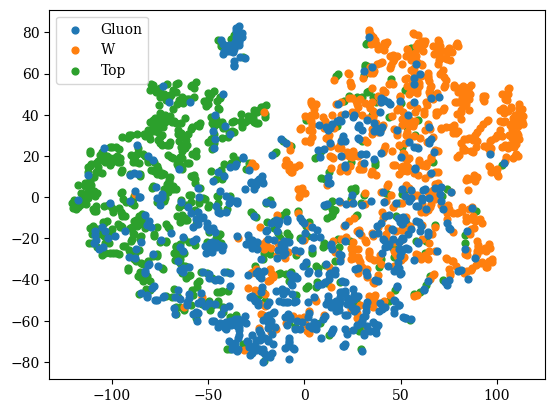

In [280]:
fig2d = plt.figure()
ax = plot_filtered(X_emb, lbls, [0, 2, 4], fig2d)
ax.legend()
plt.show()

In [19]:
fig2d.savefig('models/tsne'+model_name+'.pdf')

In [ ]:
17, 28, 25, 35, 38, 32, 26, 27, 20, 16

### 3D

In [43]:
X_emb, lbls = tsne(latent_jets, labels_jets, [0, 2, 4], 2000, n_components=3, perplexity=20)

using cuda
initializing...
skipping PCA because initial_dims is larger than input dimensionality
computing p-values...


  0%|          | 0/2000 [00:00<?, ?it/s]

fitting...


  0%|          | 0/2000 [00:00<?, ?it/s]

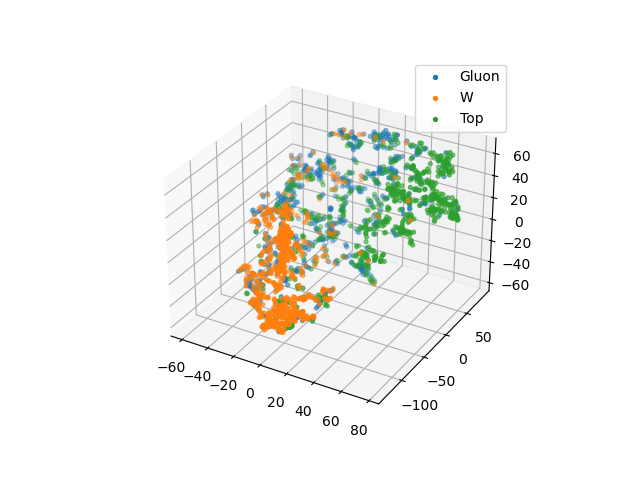

In [44]:
%matplotlib ipympl
fig3d = plt.figure()
ax = plot_tsne(X_emb, lbls, [0, 2, 4], fig3d)
ax.legend()
plt.show()

In [90]:
fig.savefig('tsne_10_latent_dim_wt.pdf')

## K-Means + accuracy

In [271]:
def kmeans_acc(y_pred, y_true):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    """
    #y_true = y_true.astype(np.int64)
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in np.unique(y_pred):
        w[i, :] = y_true[y_pred==i].bincount()
    ind = linear_sum_assignment(w.max() - w)
    ind = np.asarray(ind)
    ind = np.transpose(ind)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.shape[0]

def plot_kmeans(X_emb, c_lbls, lbls, fig):

    if type(c_lbls) is torch.Tensor:
        true_ids = c_lbls.numpy().copy()
    else:
        true_ids = c_lbls.copy()
    true_ids[c_lbls==0] = lbls[c_lbls==0].bincount().argmax()
    true_ids[c_lbls==1] = lbls[c_lbls==1].bincount().argmax()
    true_ids[c_lbls==2] = lbls[c_lbls==2].bincount().argmax()

    ax1 = plot_filtered(X_emb, true_ids, [0, 2, 4], fig, 121)
    ax2 = plot_filtered(X_emb, lbls, [0, 2, 4], fig, 122)
    #ax1.legend(prop={'size':FONTSIZE-4})
    ax2.sharey(ax1)
    for ax in (ax1, ax2):
        ax.grid(color='lightgrey', alpha=0.3)
        ax.set_axisbelow(True)
        ax.tick_params(length=0, labelbottom=False, labelleft=False)
   

    return ax1, ax2

In [281]:
c_ids_torch, c_c_torch = kmeans(torch.tensor(X_emb), num_clusters=3, distance='euclidean', device='cuda')

c_ids_skl = KMeans(3, max_iter=1000, tol=1e-5).fit_predict(X_emb)

running k-means on cuda..


[running kmeans]: 17it [00:00, 487.78it/s, center_shift=0.000000, iteration=17, tol=0.000100]


In [282]:
accuracy_torch = kmeans_acc(c_ids_torch, lbls)
accuracy_skl   = kmeans_acc(c_ids_skl, lbls)
print(f'Accuracy w/ kmeans-torch: {accuracy_torch:.2%}', 
      f'\nAccuracy w/ scikit-learn: {accuracy_skl:.2%}')

Accuracy w/ kmeans-torch: 67.55% 
Accuracy w/ scikit-learn: 67.55%


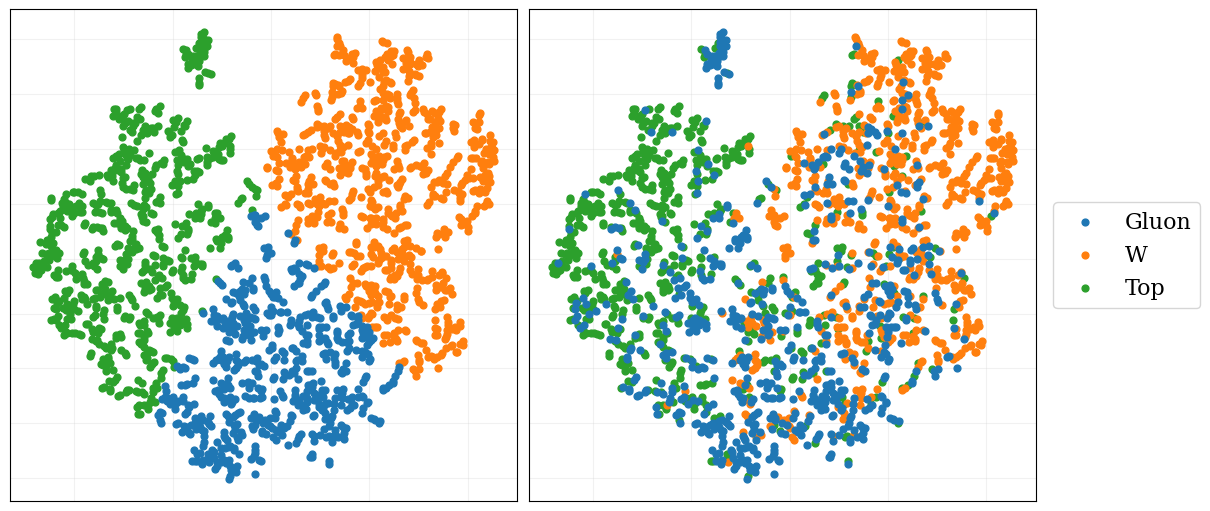

In [284]:
fig_km = plt.figure(figsize=(12, 5), constrained_layout=True)
axs = plot_kmeans(X_emb, c_ids_skl, lbls, fig_km)
axs[1].legend(prop={'size':FONTSIZE-4}, bbox_to_anchor=[1.18, 0.5], loc='center')

plt.show()

In [285]:
fig_km.savefig('plots/km_vs_true'+model_name+'.pdf')

## DBSCAN

In [111]:
c_ids_dbs = DBSCAN(eps=18, min_samples=100, n_jobs=-1).fit_predict(X_emb)
np.unique(c_ids_dbs)

array([-1,  0,  1,  2,  3])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


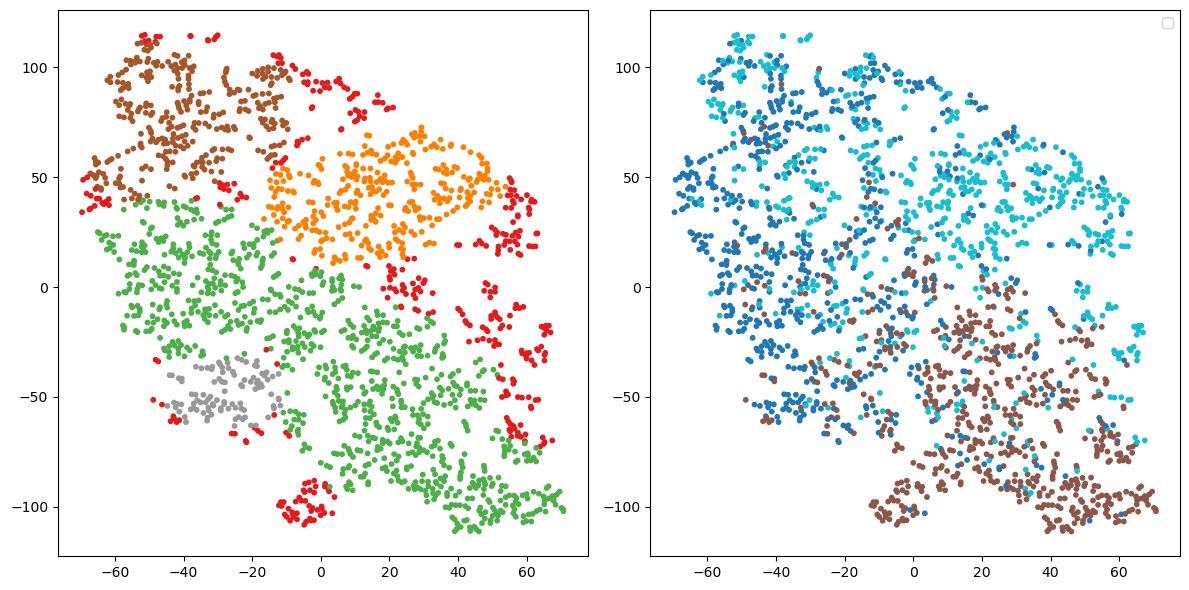

In [112]:
fig_dbs = plt.figure(figsize=(12, 6), tight_layout=True)
ax1 = plot_tsne(X_emb, c_ids_dbs, np.unique(c_ids_dbs), fig_dbs, 121, 'Set1')
ax2 = plot_tsne(X_emb, lbls, [0, 2, 4], fig_dbs, 122, 'tab10')
ax2.legend()
plt.show()

In [ ]:
accuracy_dbscan= kmeans_acc(c_ids_dbs, lbls)
print(f'Accuracy w/ kmeans-torch: {accuracy_torch:.2%}', 
      f'\nAccuracy w/ scikit-learn: {accuracy_skl:.2%}')